# Zeropoints Comparison

## Environment: anaconda-2.7 

In [212]:
import sys
print sys.executable
# Hack!, this avoids messing with NERSC's config file for jupyter hub
sys.path.append('/global/homes/k/kaylanb/repos/astrometry.net')
print sys.path

/anaconda2/bin/python
['', '/anaconda2/lib/python27.zip', '/anaconda2/lib/python2.7', '/anaconda2/lib/python2.7/plat-linux2', '/anaconda2/lib/python2.7/lib-tk', '/anaconda2/lib/python2.7/lib-old', '/anaconda2/lib/python2.7/lib-dynload', '/global/homes/k/kaylanb/.local/lib/python2.7/site-packages', '/anaconda2/lib/python2.7/site-packages/Sphinx-1.4.1-py2.7.egg', '/anaconda2/lib/python2.7/site-packages/setuptools-23.0.0-py2.7.egg', '/anaconda2/lib/python2.7/site-packages', '/anaconda2/lib/python2.7/site-packages/IPython/extensions', '/global/u2/k/kaylanb/.ipython', '/global/homes/k/kaylanb/repos/astrometry.net', '/global/homes/k/kaylanb/repos/astrometry.net', '/global/homes/k/kaylanb/repos/astrometry.net', '/global/homes/k/kaylanb/repos/astrometry.net']


## Need more packages?

In [213]:
# Easy if pip, conda installable
#!/anaconda2/bin/pip install ...
#!/anaconda2/bin/conda install ...

# Main()

Run [legacy-zeropoints-qa.py](https://github.com/legacysurvey/legacypipe/blob/57fd01b80ed6af65543a1177798977da45975f3a/py/legacyccds/legacy-zeropoints.py) like this `"python legacy-zeropoints-qa.py"` to analyze everything. 

See below to walk through it step by step.

In [214]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import fitsio
import glob
import os
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from astrometry.util.fits import fits_table, merge_tables

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
# Merge tables
# a for Arjun, j for John
j_cat,a_cat= [],[]
fns=glob.glob('/project/projectdirs/desi/users/burleigh/test_data/old/zeropoint*v2.fits')
for fn in fns:
    j_cat.append( fits_table(fn) )
    a_fn= os.path.join(os.path.dirname(fn), 'arjun_'+os.path.basename(fn))
    a_cat.append( fits_table(a_fn) )
# fns=glob.glob('/project/projectdirs/desi/users/burleigh/test_data/zeropoint*v2.fits')
# for fn in fns:
#     a_cat.append( fits_table(fn) )
#     j_fn= os.path.join(os.path.dirname(fn), 'units_1arcsec_'+os.path.basename(fn))
#     j_cat.append( fits_table(j_fn) )
j = merge_tables(j_cat, columns='fillzero')
a = merge_tables(a_cat, columns='fillzero')


In [233]:
%%file translate.py
import numpy as np
import matplotlib.pyplot as plt

class Translator(object):
    def __init__(self,j,a):
        self.j=j
        self.a=a
        #
        sj,sa= set(self.j.get_columns()),set(self.a.get_columns())
        self.both=list(sj.intersection(sa))
        self.a_only=list(sa.difference(sj))
        self.j_only=list(sj.difference(sa))
#         self.print_set('both',self.both)
#         self.print_set('a_only',self.a_only)
#         self.print_set('j_only',self.j_only)
        #
        self.translate()
        # numeric vs. str keys
        self.float_or_str()
        # What did we miss?
        print '----\nmissing from Johns\n----'
        for key in j.get_columns():
            if key not in self.j2a.keys():
                print '%s' % key
        vals=[v for k,v in self.j2a.items()]
        print '----\nmissing from Arjuns\n----'
        for key in a.get_columns():
            if key not in vals:
                print '%s' % key
                
    def compare(self):
        # Comparisons
        self.compare_strings()
        self.compare_floats_ints()
            
        
    def map_a2j(self,key):
        d= dict(ra='ra_bore',dec='dec_bore',\
                arawgain='gain',\
                ccdhdunum='image_hdu',\
                zpt='zptavg',\
                filename='image_filename',\
                naxis1='width',\
                naxis2='height')
        return d[key]
        
    def translate(self):
        j2a={}
        skip=[]
        for key in self.both:
            if key in ['zpt','ra','dec']:
                skip+= [key]
            else:
                j2a[key]=key
        for key in self.a_only:
            if np.any((key.startswith('ccdhdu'),\
                       key.startswith('ccdnmatcha'),\
                       key.startswith('ccdnmatchb'),\
                       key.startswith('ccdnmatchc'),\
                       key.startswith('ccdnmatchd'),\
                       key.startswith('ccdzpta'),\
                       key.startswith('ccdzptb'),\
                       key.startswith('ccdzptc'),\
                       key.startswith('ccdzptd'),\
                       key.startswith('ccdnum')),axis=0):
                skip+= [key]
            elif key.startswith('ccd'):
                j2a[key.replace('ccd','')]=key
            else:
                skip+= [key]
        for key in skip:
            try: 
                j2a[ self.map_a2j(key) ]= key
            except KeyError:
                pass # Missing this key, will find these later
        self.j2a=j2a
        print 'John --> Arjun'
        for key in self.j2a.keys():
            print '%s --> %s' % (key,self.j2a[key])
    
    def float_or_str(self):
        self.typ=dict(floats=[],ints=[],strs=[])
        for key in self.j2a.keys():
            typ= type(self.j.get(key)[0])
            if np.any((typ == np.float32,\
                       typ == np.float64),axis=0):
                self.typ['floats']+= [key]
            elif np.any((typ == np.int16,\
                         typ == np.int32),axis=0):
                self.typ['ints']+= [key]
            elif typ == np.string_:
                self.typ['strs']+= [key]
            else:
                print 'WARNING: unknown type for key=%s, ' % key,typ
    
    def print_set(self,text,s):
        print '%s\n' % text,np.sort(list(s))
        
    def compare_strings(self):
        print '----\nString comparison, John --> Arjun\n----'
        for s_key in self.typ['strs']:
            print '%s:%s --> %s:%s' % (s_key, self.j.get(s_key)[0],\
                                       self.j2a[s_key], self.a.get( self.j2a[s_key] )[0])
            
    def compare_floats_ints(self):
        panels=len(self.typ['floats'])+len(self.typ['ints'])
        cols=3
        if panels % cols == 0:
            rows=panels/cols
        else:
            rows=panels/cols+1
        # print cols,rows
        fig,axes= plt.subplots(rows,cols,figsize=(20,30))
        ax=axes.flatten()
        plt.subplots_adjust(hspace=0.4,wspace=0.3)
        cnt=-1
        for key in self.typ['floats']+self.typ['ints']:
            cnt+=1
            arjun= self.a.get( self.j2a[key] )
            john= self.j.get(key)
            y= (arjun-john)/john
            if key in ['transp','raoff','decoff','rarms','decrms',\
                       'phrms','phoff','skyrms','skycounts',\
                       'nstar','nmatch','width','height']:
                ax[cnt].scatter(john,arjun)
                ylab=ax[cnt].set_ylabel('Arjun',fontsize='small')
            else:
                ax[cnt].scatter(john,y) 
                ylab=ax[cnt].set_ylabel('(Arjun-John)/John',fontsize='small')
                ax[cnt].set_ylim([-0.1,0.1])
            xlab=ax[cnt].set_xlabel('%s (John)' % key,fontsize='small')
        # plt.savefig("test.png",\
        #             bbox_extra_artists=[xlab,ylab], bbox_inches='tight',dpi=150)
            




Overwriting translate.py


In [236]:
from translate import Translator
t=Translator(j,a)

John --> Arjun
nstar --> ccdnstar
crpix1 --> crpix1
crpix2 --> crpix2
raoff --> ccdraoff
transp --> ccdtransp
height --> naxis2
cd2_1 --> cd2_1
cd2_2 --> cd2_2
zptavg --> zpt
propid --> propid
ra_bore --> ra
dec --> ccddec
phrms --> ccdphrms
skymag --> ccdskymag
image_hdu --> ccdhdunum
zpt --> ccdzpt
width --> naxis1
ra --> ccdra
decoff --> ccddecoff
image_filename --> filename
airmass --> airmass
crval2 --> crval2
skyrms --> ccdskyrms
skycounts --> ccdskycounts
crval1 --> crval1
ccdname --> ccdname
object --> object
mdncol --> ccdmdncol
rarms --> ccdrarms
avsky --> avsky
cd1_1 --> cd1_1
gain --> arawgain
expnum --> expnum
ha --> ha
decrms --> ccddecrms
exptime --> exptime
nmatch --> ccdnmatch
cd1_2 --> cd1_2
date_obs --> date_obs
ut --> ut
filter --> filter
dec_bore --> dec
phoff --> ccdphoff
mjd_obs --> mjd_obs
----
missing from Johns
----
camera
expid
pixscale
----
missing from Arjuns
----
seeing
fwhm
ccdnum
ccdzpta
ccdzptb
ccdzptc
ccdzptd
ccdnmatcha
ccdnmatchb
ccdnmatchc
ccdnmatchd

----
String comparison, John --> Arjun
----
propid:2016A-0453 --> propid:2016A-0453
image_filename:/scratch2/scratchdirs/kaylanb/cosmo/staging/mosaicz/MZLS_CP/CP201 --> filename:k4m_160203_015632_ooi_zd_v2.fits
ccdname:CCD1 --> ccdname:ccd1
object:OBJECT Observation(s) --> object:OBJECT Observation(s)
ha:00:20:54.24 --> ha:00:20:54.24
date_obs:2016-02-03 --> date_obs:2016-02-03
ut:01:56:32 --> ut:01:56:32
filter:z --> filter:z


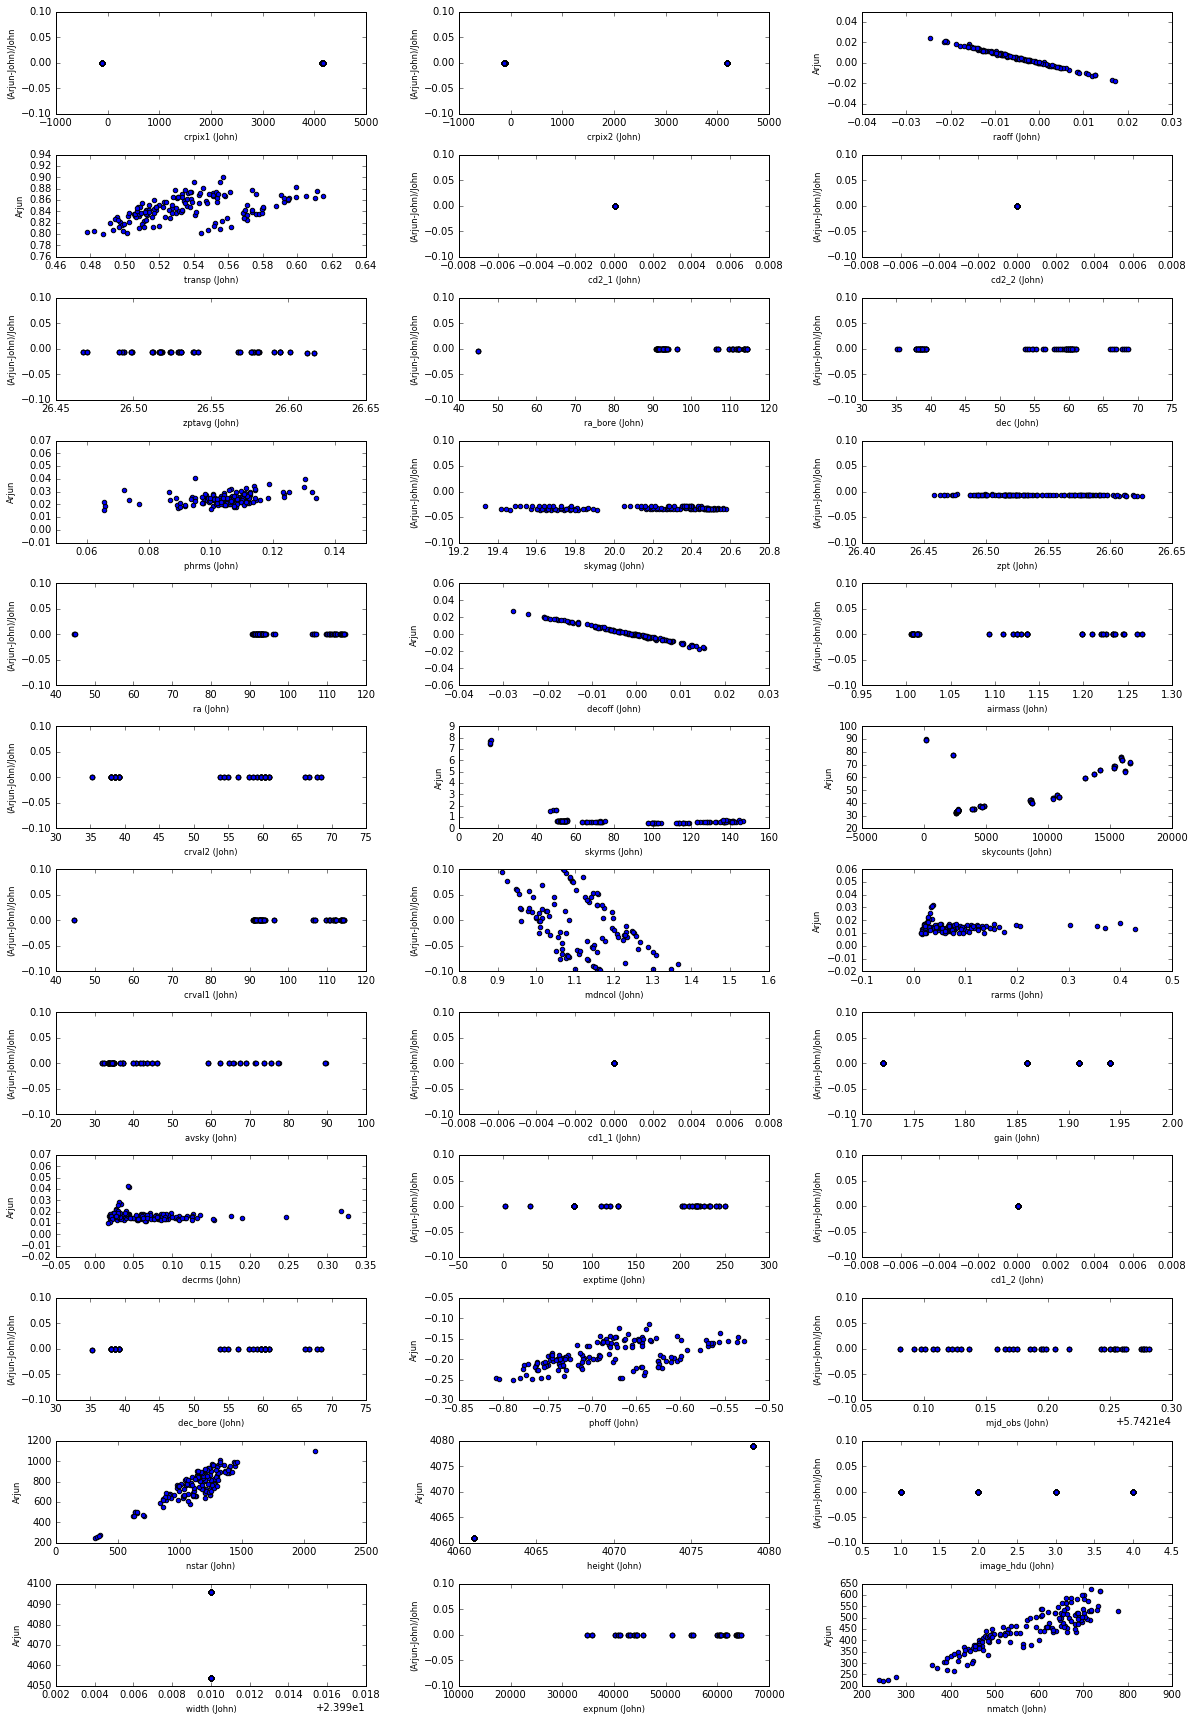

In [237]:
t.compare()

# Old Below

In [202]:
# Keys with SAME NAME
fig,axes= plt.subplots(4,4,figsize=(18,10))
ax=axes.flatten()
hw=0.4
plt.subplots_adjust(hspace=hw,wspace=hw)
cnt=-1
for key in sj.intersection(sa):
    if key in ['date_obs','filter','object','propid','ccdname']:
        continue
    if key in ['ha','ut']:
        continue
    if key in ['zpt']:
        continue #A zpt not -> J zpt
    cnt+=1
    y= (a.get(key) - j.get(key))/a.get(key)
    ax[cnt].scatter(a.get(key),y) 
    xlab=ax[cnt].set_xlabel('A: %s' % key)
    ylab=ax[cnt].set_ylabel('(A-J)/A: %s' % key)
    ax[cnt].set_ylim([-0.01,0.01])
plt.savefig("same_keys_same_data.png",\
            bbox_extra_artists=[xlab,ylab], bbox_inches='tight',dpi=150)

36

----
String comparison, John --> Arjun
----
propid:2016A-0453 --> propid:2016A-0453
image_filename:/scratch2/scratchdirs/kaylanb/cosmo/staging/mosaicz/MZLS_CP/CP201 --> filename:k4m_160203_015632_ooi_zd_v2.fits
ccdname:CCD1 --> ccdname:ccd1
object:OBJECT Observation(s) --> object:OBJECT Observation(s)
ha:00:20:54.24 --> ha:00:20:54.24
date_obs:2016-02-03 --> date_obs:2016-02-03
ut:01:56:32 --> ut:01:56:32
filter:z --> filter:z


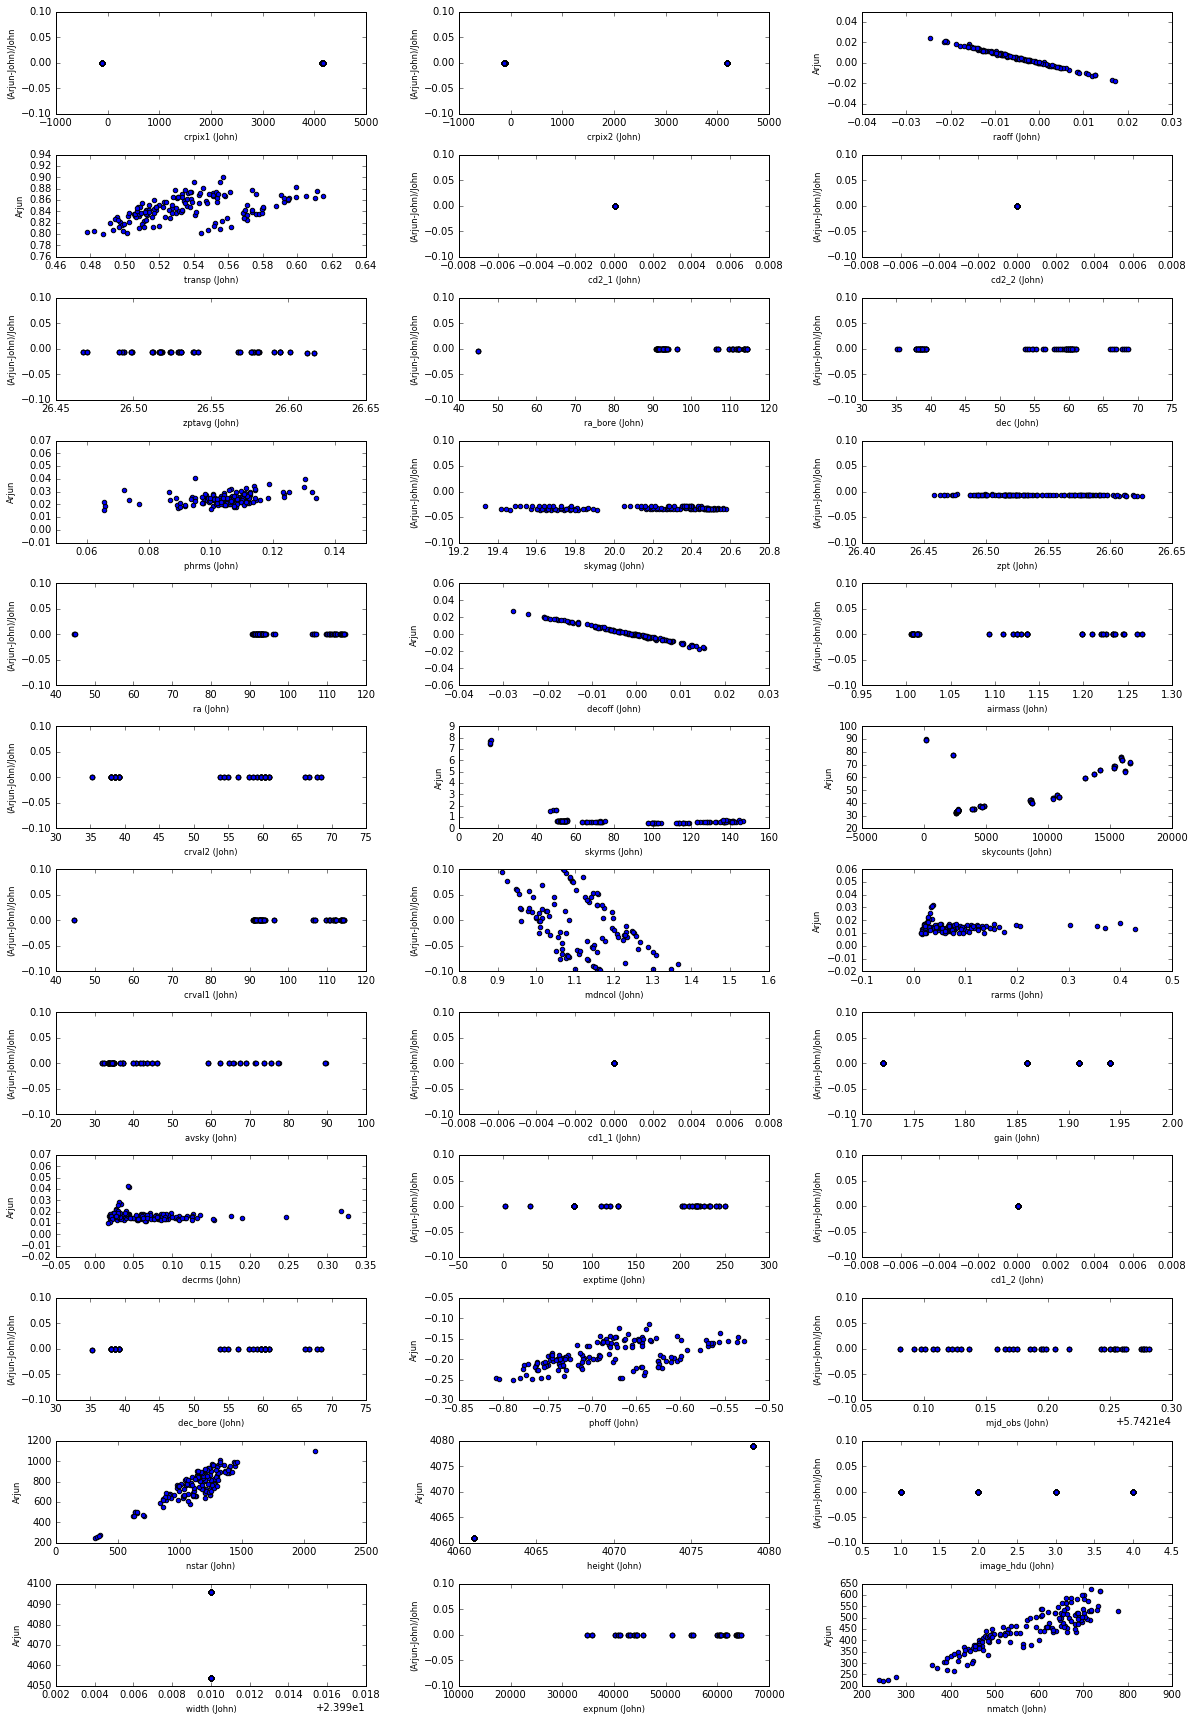

In [82]:
print "rows: John=%d, Arjun=%d" % (len(j),len(a))
print "cols: John=%d, Arjun=%d" % (len(j.get_columns()),len(a.get_columns()))

def pset(s):
    print np.sort(list(s))

sj,sa= set(j.get_columns()),set(a.get_columns())
print "Both:\n",pset(sj.intersection(sa))
print "Arjun Only:\n",pset(sa.difference(sj))
print "John Only:\n",pset(sj.difference(sa))

rows: John=148, Arjun=148
cols: John=47, Arjun=59
Both:
['airmass' 'avsky' 'ccdname' 'cd1_1' 'cd1_2' 'cd2_1' 'cd2_2' 'crpix1'
 'crpix2' 'crval1' 'crval2' 'date_obs' 'dec' 'expnum' 'exptime' 'filter'
 'ha' 'mjd_obs' 'object' 'propid' 'ra' 'ut' 'zpt']
None
Arjun Only:
['arawgain' 'badimg' 'ccddec' 'ccddecoff' 'ccddecrms' 'ccdhdunum'
 'ccdmdncol' 'ccdnmatch' 'ccdnmatcha' 'ccdnmatchb' 'ccdnmatchc'
 'ccdnmatchd' 'ccdnstar' 'ccdnum' 'ccdphoff' 'ccdphrms' 'ccdra' 'ccdraoff'
 'ccdrarms' 'ccdskycounts' 'ccdskymag' 'ccdskyrms' 'ccdtransp' 'ccdzpt'
 'ccdzpta' 'ccdzptb' 'ccdzptc' 'ccdzptd' 'filename' 'fwhm' 'naxis1'
 'naxis2' 'psfab' 'psfpa' 'seeing' 'temp']
None
John Only:
['camera' 'dec_bore' 'decoff' 'decrms' 'expid' 'gain' 'height'
 'image_filename' 'image_hdu' 'mdncol' 'nmatch' 'nstar' 'phoff' 'phrms'
 'pixscale' 'ra_bore' 'raoff' 'rarms' 'skycounts' 'skymag' 'skyrms'
 'transp' 'width' 'zptavg']
None


In [149]:
j.get('expid')[:2],j.get('image_filename')[:2]

(array(['00015632-CCD1', '00015632-CCD2'], 
       dtype='|S16'),
 array(['/scratch2/scratchdirs/kaylanb/cosmo/staging/mosaicz/MZLS_CP/CP201',
        '/scratch2/scratchdirs/kaylanb/cosmo/staging/mosaicz/MZLS_CP/CP201'], 
       dtype='|S65'))

In [131]:
a.get('ccdra')[:4],j.get('ra')[:4],a.get('ccdra')[:4]

(array([ 44.57461481,  44.57441716,  44.9539877 ,  44.95623023]),
 array([ 44.57457114,  44.57437284,  44.95394341,  44.95618627]),
 array([ 44.57461481,  44.57441716,  44.9539877 ,  44.95623023]))

In [97]:
a.get('ccdrarms')[:4],j.get('rarms')[:4]

(array([ 0.03224996,  0.02602155,  0.03000374,  0.03094478], dtype=float32),
 array([ 0.03793217,  0.03256905,  0.03435664,  0.03501526], dtype=float32))

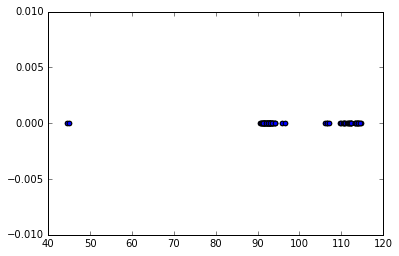

In [101]:
a_key,j_key= 'ccdra','ra'
y= (a.get(a_key) - j.get(j_key))/a.get(a_key)
plt.scatter(a.get(a_key),y)

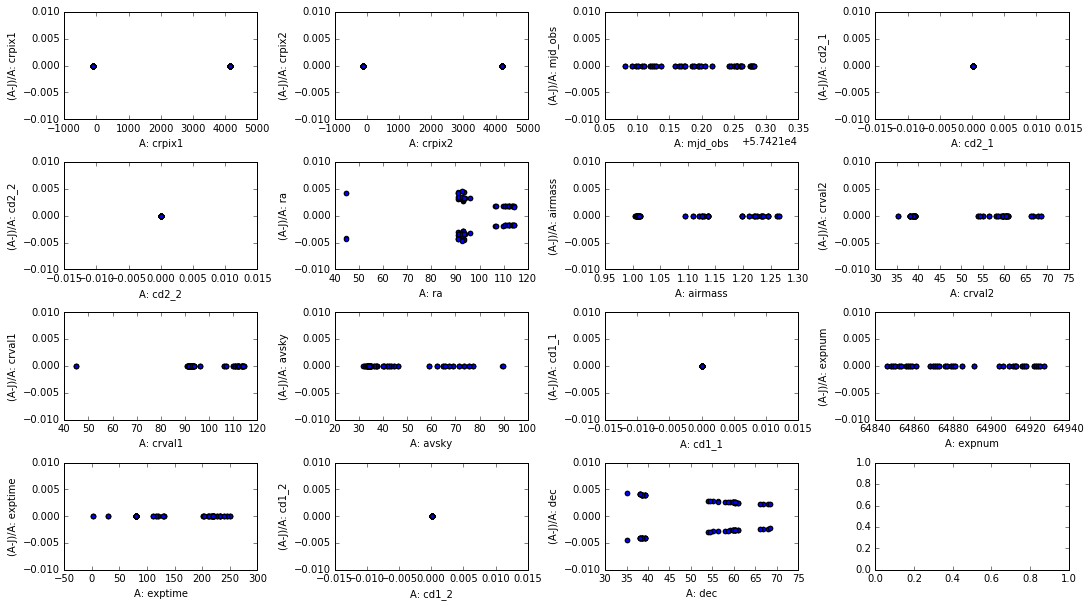

In [88]:
# Keys with SAME NAME
fig,axes= plt.subplots(4,4,figsize=(18,10))
ax=axes.flatten()
hw=0.4
plt.subplots_adjust(hspace=hw,wspace=hw)
cnt=-1
for key in sj.intersection(sa):
    if key in ['date_obs','filter','object','propid','ccdname']:
        continue
    if key in ['ha','ut']:
        continue
    if key in ['zpt']:
        continue #A zpt not -> J zpt
    cnt+=1
    y= (a.get(key) - j.get(key))/a.get(key)
    ax[cnt].scatter(a.get(key),y) 
    xlab=ax[cnt].set_xlabel('A: %s' % key)
    ylab=ax[cnt].set_ylabel('(A-J)/A: %s' % key)
    ax[cnt].set_ylim([-0.01,0.01])
plt.savefig("same_keys_same_data.png",\
            bbox_extra_artists=[xlab,ylab], bbox_inches='tight',dpi=150)
    

## Mapping between Arjun's and John's keys

Use the `%%file` magic function to save code to a file `maps.py`. We can then import it as a **module** 

In [89]:
%%file maps.py

import numpy as np
def a2j(key):
    d= dict(arawgain='gain',\
            ccddec='dec_bore',\
            ccdra='ra_bore',\
            ccddecoff='decoff',\
            ccdraoff='raoff',\
            ccddecrms='decrms',\
            ccdrarms='rarms',\
            ccdhdunum='image_hdu',\
            ccdmdncol='mdncol',\
            ccdnmatch='nmatch',\
            ccdnstar='nstar',\
            ccdphoff='phoff',\
            ccdphrms='phrms',\
            ccdskycounts='skycounts',\
            ccdskymag='skymag',\
            ccdskyrms='skyrms',\
            ccdtransp='transp',\
            ccdzpt='zpt',\
            zpt='zptavg',\
            filename='image_filename',\
            naxis1='width',\
            naxis2='height')
    return d[key]

def lims_for_key(key):
    d= dict(arawgain=0.05,\
            ccddec=0.05,\
            ccdra=0.05,\
            ccddecoff='none',\
            ccdraoff='none',\
            ccddecrms='none',\
            ccdrarms='none',\
            ccdhdunum='none',\
            ccdmdncol=0.15,\
            ccdnmatch='none',\
            ccdnstar='none',\
            ccdphoff='none',\
            ccdphrms='none',\
            ccdskycounts='none',\
            ccdskymag='none',\
            ccdskyrms='none',\
            ccdtransp='none',\
            ccdzpt=0.05,\
            zpt=0.02,\
            filename='none',\
            naxis1='none',\
            naxis2='none')
    return d[key]

def a_not_in_j():
    return ['badimg','ccdnum',\
          'ccdnmatcha','ccdnmatchb','ccdnmatchc','ccdnmatchd',\
          'ccdzpta','ccdzptb','ccdzptc','ccdzptd',\
          'fwhm','psfab','psfpa','seeing','temp']
    
def j_not_in_a():
    return ['camera','expid','pixscale']

def convert_j2a(j,key):
    '''multiply john's number by this to convert to arjuns'''
    plus= dict(phoffadfafd=2.5*np.log10(j.get('gain')),\
            )
    mult= dict(phoffaggg=j.get('gain'),\
               skycountsadfa=1./j.get('exptime')
            )
    if key in plus.keys():
        return j.get(key)+plus[key]
    elif key in mult.keys():
        return j.get(key)*mult[key]
    else:
        return j.get(key)

Overwriting maps.py


cnt=19


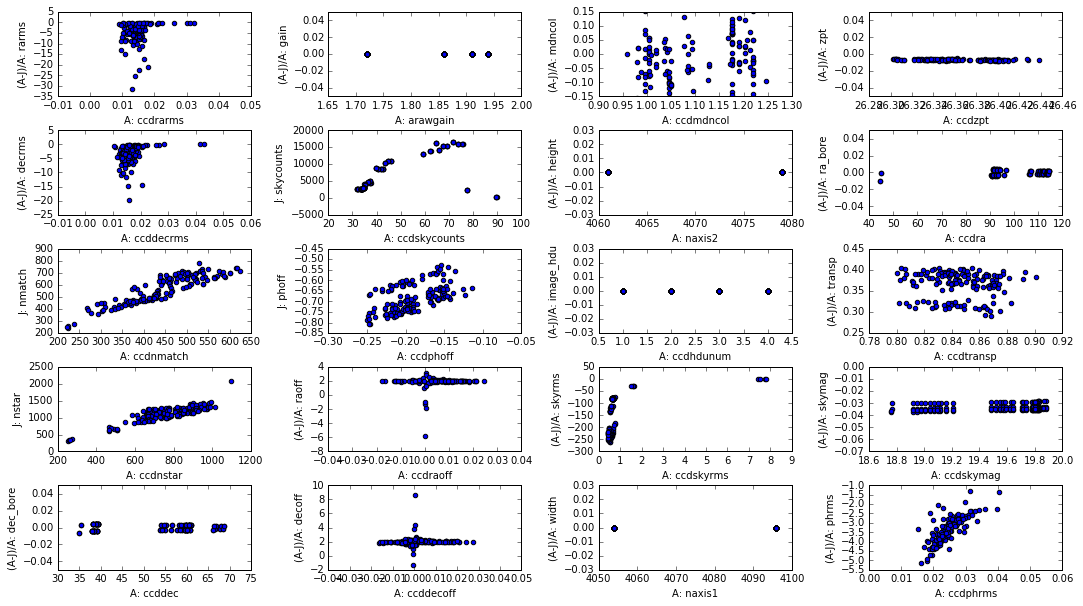

In [90]:
# SAME DATA, Different keys
import maps
fig,axes= plt.subplots(5,4,figsize=(18,10))
ax=axes.flatten()
hw=0.4
plt.subplots_adjust(hspace=hw,wspace=hw)
cnt=-1
# Arjun only
for key in sa.difference(sj):
    #avoid= 
    if key in maps.a_not_in_j():
        continue
    if key in ['filename']:
        continue
    cnt+=1
    jval= maps.convert_j2a(j, maps.a2j(key) )
    if key in ['ccdnmatch','ccdnstar','ccdskycounts','ccdphoff']:
#         y= j.get( maps.a2j(key) )
        y=jval
        ax[cnt].scatter(a.get(key),y) 
        xlab=ax[cnt].set_xlabel('A: %s' % key)
        ylab=ax[cnt].set_ylabel('J: %s' % maps.a2j(key) )
    else:
#         y= (a.get(key) - j.get( maps.a2j(key) ))/a.get(key)
        y= (a.get(key) - jval)/a.get(key)
        ax[cnt].scatter(a.get(key),y) 
        xlab=ax[cnt].set_xlabel('A: %s' % key)
        ylab=ax[cnt].set_ylabel('(A-J)/A: %s' % maps.a2j(key) )
    ylim= maps.lims_for_key(key)
    if ylim != 'none':
        ax[cnt].set_ylim([-ylim,ylim])
plt.savefig("same_data_diff_keys.png",\
            bbox_extra_artists=[xlab,ylab], bbox_inches='tight',dpi=150)
print "cnt=%d" % cnt

In [46]:
# If STRINGS not identicial, print them 
same= ['date_obs','filter','object','propid','ccdname','ha','ut']
mapped= ['filename']
for key in same:
    if a.get(key)[0] != j.get(key)[0]:
        print "Arjuns, Johns (%s)" % key
        for i in range(4): print a.get(key)[i],j.get(key)[i]
for key in mapped:
    if a.get(key)[0] != j.get( maps.a2j(key) )[0]:
        print "Arjuns, Johns (%s)" % key
        for i in range(4): print a.get(key)[i],j.get( maps.a2j(key) )[i]


Arjuns, Johns (ccdname)
ccd1 CCD1
ccd2 CCD2
ccd3 CCD3
ccd4 CCD4
Arjuns, Johns (filename)
k4m_160203_021214_ooi_zd_v2.fits /scratch2/scratchdirs/kaylanb/cosmo/staging/mosaicz/MZLS_CP/CP201
k4m_160203_021214_ooi_zd_v2.fits /scratch2/scratchdirs/kaylanb/cosmo/staging/mosaicz/MZLS_CP/CP201
k4m_160203_021214_ooi_zd_v2.fits /scratch2/scratchdirs/kaylanb/cosmo/staging/mosaicz/MZLS_CP/CP201
k4m_160203_021214_ooi_zd_v2.fits /scratch2/scratchdirs/kaylanb/cosmo/staging/mosaicz/MZLS_CP/CP201


In [47]:
# Totally DIFFERENT keys, print them
print "Arjun:"
for key in maps.a_not_in_j():
    print "%s: " % key, a.get(key)[0]
    
print "\nJohn:"
for key in maps.j_not_in_a():
    print "%s: " % key, j.get(key)[0]

Arjun:
badimg:  0
ccdnum:  1
ccdnmatcha:  100
ccdnmatchb:  95
ccdnmatchc:  117
ccdnmatchd:  117
ccdzpta:  26.372
ccdzptb:  26.3575
ccdzptc:  26.3725
ccdzptd:  26.3681
fwhm:  1.999
psfab:  1.0948
psfpa:  113.972
seeing:  2.23042
temp:  -0.9

John:
camera:  mosaic3
expid:  00021214-CCD1
pixscale:  0.259628


# ra,dec covered during MzLS Feb2016

what bricks should I run for the v2, v3 comparison?

In [15]:
# Merge tables
a=[]
# fns=glob.glob('/project/projectdirs/desi/users/burleigh/test_data/arjuns_feb2016_v2/zeropoint-k4m_160207_125*_ooi_zd_v2.fits')
fns=glob.glob('/project/projectdirs/desi/users/burleigh/test_data/arjuns_feb2016_v2/zeropoint-*v2.fits')
for fn in fns:
    a.append( fits_table(fn) )
a = merge_tables(a, columns='fillzero')

In [25]:
a= fits_table('/project/projectdirs/desi/users/burleigh/test_data/arjuns_feb2016_v2/mzls-zpt-2016feb-v2.fits')

In [30]:
bricks=fits_table('/project/projectdirs/desi/users/burleigh/test_data/survey-bricks.fits.gz')

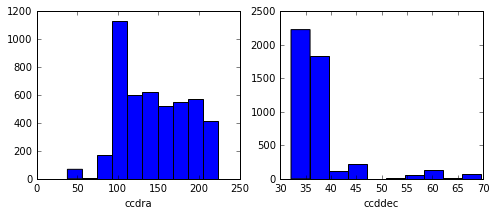

In [26]:
fix,ax= plt.subplots(1,2,figsize=(8,3))
plt.subplots_adjust(wspace=0.2)
for cnt,key in zip(range(2),['ccdra','ccddec']):
    ax[cnt].hist(a.get(key))
    ax[cnt].set_xlabel(key)

In [46]:
bricks.get_columns()

['brickname',
 'brickid',
 'brickq',
 'brickrow',
 'brickcol',
 'ra',
 'dec',
 'ra1',
 'ra2',
 'dec1',
 'dec2']

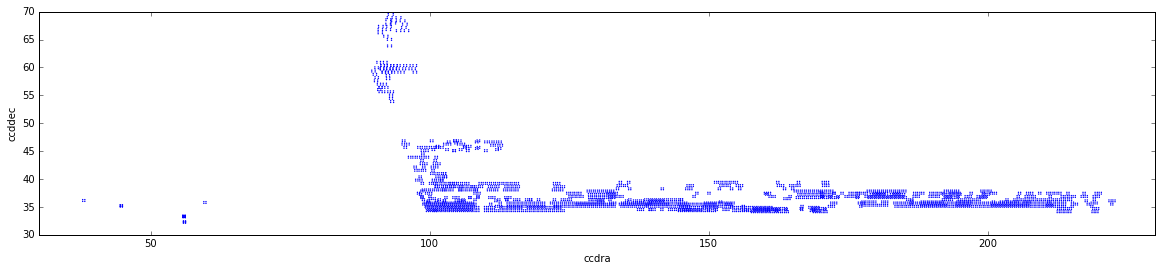

In [68]:
fix,ax= plt.subplots(figsize=(20,4))
xlim=[30,230]
ylim=[30,70]

ax.scatter(a.get('ccdra'),a.get('ccddec'),c='b',edgecolors='none',s=2.)
xlab=ax.set_xlabel('ccdra')
ylab=ax.set_ylabel('ccddec')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.savefig('coverage_1.png',bbox_extra_artists=[xlab,ylab], bbox_inches='tight',dpi=150)

In [38]:
len(bricks),len(bricks[ind])

(662174, 3344)

In [69]:
bricks.get_brickname('')

<bound method tabledata.get_columns of <tabledata object with 662174 rows and 11 columns: brickname, brickq, ra2, ra, ra1, brickrow, brickcol, dec, dec1, dec2, brickid>>

662174 1671


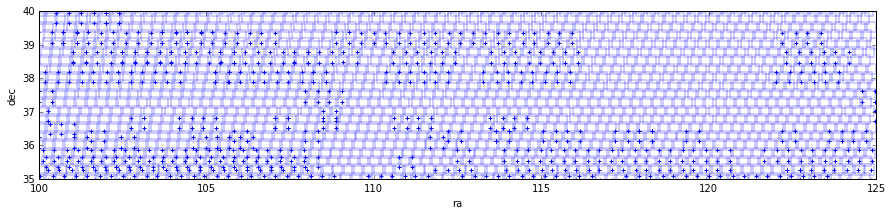

In [64]:
xlim=[100,125]
ylim=[35,40]
ind=np.all((bricks.get('ra') >= xlim[0],bricks.get('ra') <= xlim[1],\
            bricks.get('dec') >= ylim[0],bricks.get('dec') <= ylim[1]),axis=0)
print len(bricks),len(bricks[ind])

fix,ax= plt.subplots(figsize=(15,3))
# CCD centers
ax.scatter(a.get('ccdra'),a.get('ccddec'),c='b',edgecolors='none',marker='+',s=20.)
# Brick boundaries
patches = []
for ra1,ra2,dec1,dec2 in zip(bricks[ind].get('ra1'),bricks[ind].get('ra2'),\
                            bricks[ind].get('dec1'),bricks[ind].get('dec2')):
    rect = mpatches.Rectangle((ra1,dec1),dec2-dec1,ra2-ra1, \
                              color='none',fc='none',ec="r")
    patches.append(rect)
collection = PatchCollection(patches, alpha=0.2, facecolors='none',edgecolors='b',linewidths=2) #cmap=['r']*len(plt.cm.hsv), alpha=0.2)
ax.add_collection(collection)

# plt.scatter(bricks.get('ra')[ind],bricks.get('dec')[ind],c='r',marker='+',edgecolors='none',s=5.)

xlab=plt.xlabel('ra')
ylab=plt.ylabel('dec')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.savefig('coverage_2.png',bbox_extra_artists=[xlab,ylab], bbox_inches='tight',dpi=150)

662174 337
wrote brick_list.txt


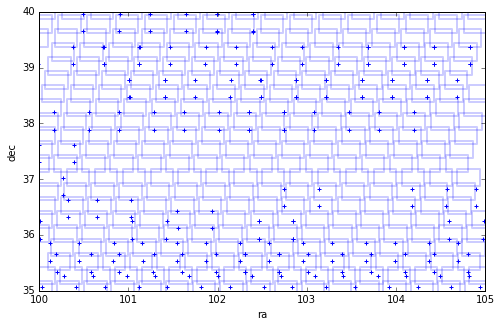

In [71]:
xlim=[100,105]
ylim=[35,40]
ind=np.all((bricks.get('ra') >= xlim[0],bricks.get('ra') <= xlim[1],\
            bricks.get('dec') >= ylim[0],bricks.get('dec') <= ylim[1]),axis=0)
print len(bricks),len(bricks[ind])

fn='brick_list.txt'
if os.path.exists(fn):
    os.remove(fn)
fin=open(fn,'w')
for bri in bricks[ind].get('brickname'):
    fin.write('%s\n' % bri)
fin.close()
print 'wrote %s' % fn

fix,ax= plt.subplots(figsize=(8,5))
# CCD centers
ax.scatter(a.get('ccdra'),a.get('ccddec'),c='b',edgecolors='none',marker='+',s=20.)
# Brick boundaries
patches = []
for ra1,ra2,dec1,dec2 in zip(bricks[ind].get('ra1'),bricks[ind].get('ra2'),\
                            bricks[ind].get('dec1'),bricks[ind].get('dec2')):
    rect = mpatches.Rectangle((ra1,dec1),dec2-dec1,ra2-ra1, \
                              color='none',fc='none',ec="r")
    patches.append(rect)
collection = PatchCollection(patches, alpha=0.2, facecolors='none',edgecolors='b',linewidths=2) #cmap=['r']*len(plt.cm.hsv), alpha=0.2)
ax.add_collection(collection)

# plt.scatter(bricks.get('ra')[ind],bricks.get('dec')[ind],c='r',marker='+',edgecolors='none',s=5.)

xlab=plt.xlabel('ra')
ylab=plt.ylabel('dec')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.savefig('coverage_3.png',bbox_extra_artists=[xlab,ylab], bbox_inches='tight',dpi=150)

(35, 42)

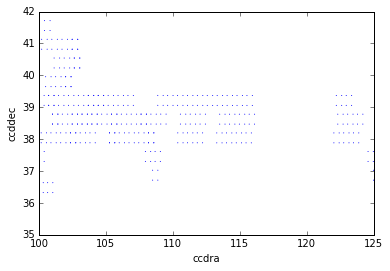

In [24]:
plt.scatter(a.get('ccdra'),a.get('ccddec'),c='b',edgecolors='none',s=1.)
xlab=plt.xlabel('ccdra')
ylab=plt.ylabel('ccddec')
plt.xlim([100,125])
plt.ylim([35,42])

In [74]:
a=np.arange(8)

In [77]:
# np.split(a,3)
np.array_split(a,3)

[array([0, 1, 2]), array([3, 4, 5]), array([6, 7])]